In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.optimize as opt
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

In [120]:
df = pd.read_csv('train_loanDataset.csv', sep=',')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [121]:
df.describe()    ## getting summary of numerical variables

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [123]:
## LoanAmount has (614 – 592) 22 missing values.
## Loan_Amount_Term has (614 – 600) 14 missing values.
## Credit_History has (614 – 564) 50 missing values
## The ApplicantIncome distribution seems to be close to mean. Same with CoapplicantIncome

In [124]:
## For the non-numerical values (e.g. Property_Area, Credit_History etc.), we can look at frequency distribution to 
## understand whether they make sense or not.
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

In [125]:
df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

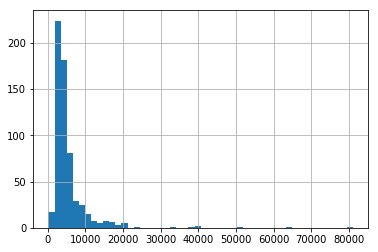

In [126]:
## Plotting histogram and box plots to study the distributions of numerical variables in detail
df['ApplicantIncome'].hist(bins=50)

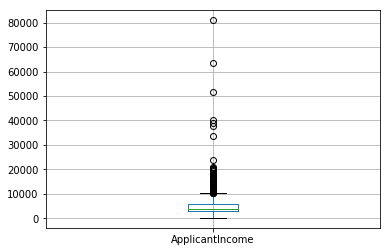

In [127]:
df.boxplot(column='ApplicantIncome')

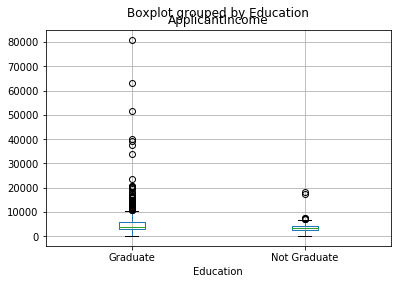

In [128]:
## Few extreme values which are the outliers
df.boxplot(column='ApplicantIncome', by = 'Education')

In [129]:
## Higher number of graduates that are outliers

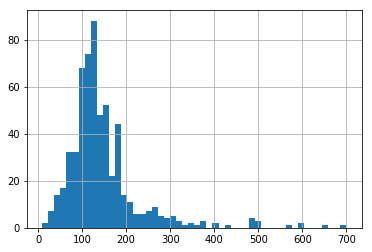

In [130]:
df['LoanAmount'].hist(bins=50)

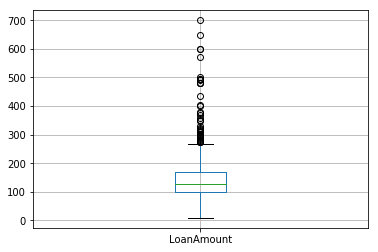

In [131]:
df.boxplot(column='LoanAmount')

In [132]:
## There are some extreme values
## LoanAmount has missing and well as extreme values values, while ApplicantIncome has a few extreme values.

## Data Transformations: 

## 1. Imputing missing values in the variables
## Reidentifying the missing values:
df.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [133]:
## imputing 'LoanAmount' with it's mean
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)

In [134]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [135]:
## Since more than 80% values are “No”, it is safe to impute the missing values as “No”
df['Self_Employed'].fillna('No',inplace=True)

## imputing others
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

In [136]:
## Data Transformation 2: 
## let’s try a log transformation to nullify the skewed histograms of LoanAmount and ApplicantIncome

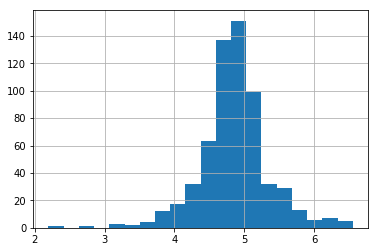

In [137]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)

In [138]:
## distribution looks much closer to normal
## some applicants have lower income but strong support Co-applicants. So it might be a good idea to combine both 
## incomes as total income and take a log transformation of the same.


df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])

In [139]:
## CONVERTING all categorical variables to numerical before starting with predictions
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes 

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [152]:
## Creating a commom function for cross-validation 
## Checking for cross-validation score error as the dataset is small.

#Generic function for making a cross validation model and accessing performance:
def cross_validation(model, data, X_train, Y_train):
  

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[X_train].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[Y_train].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[X_train].iloc[test,:], data[Y_train].iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
  
 


In [154]:
## Splitting data into X and Y


X = df[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']]

Y = df[['Loan_Status']]

## Grouping data into Train and Test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size = 0.20, random_state =0)


C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Cross-Validation Score : 80.946%


C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Accuracy : 82.927%


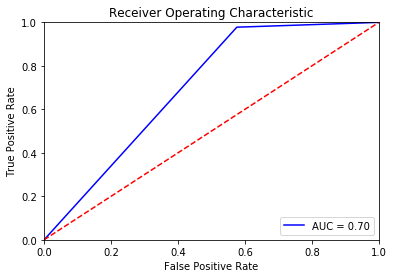

ROC_AUC Score : 0.7010101010101011


In [162]:
## 1st Algorithm --> SVM classification with linear kernel 

model_svm1 = svm.SVC(kernel='linear', C=1, gamma=1)

## creating objects for Cross-validation
X = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
Y = ['Loan_Status']
cross_validation(model_svm1, df,X, Y)

## model fitting
model_svm1.fit(X_train, Y_train)
model_svm1.score(X_train, Y_train)

#Predict Output
predictions= model_svm1.predict(X_test)

#Print accuracy
accuracy = metrics.accuracy_score(Y_test,predictions)
print ("Model Accuracy : %s" % "{0:.3%}".format(accuracy))


## ROC Error metrics:

fpr, tpr, threshold = metrics.roc_curve(Y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("ROC_AUC Score : " + str(roc_auc) )


Cross-Validation Score : 77.528%
Model Accuracy : 80.488%


C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

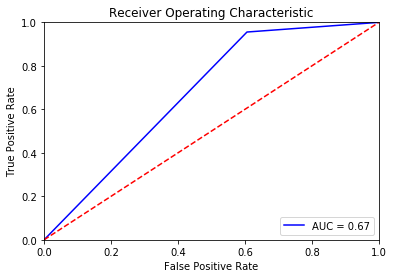

ROC_AUC Score : 0.6747474747474748


In [163]:
## SVM 2 --> SVM classification with rbf kernel 

model_svm2 = svm.SVC(kernel='rbf', C=1, gamma=1)

## creating objects for Cross-validation
X = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
Y = ['Loan_Status']
cross_validation(model_svm2, df,X, Y)

## model fitting
model_svm2.fit(X_train, Y_train)
model_svm2.score(X_train, Y_train)

#Predict Output
predictions= model_svm2.predict(X_test)

#Print accuracy
accuracy = metrics.accuracy_score(Y_test,predictions)
print ("Model Accuracy : %s" % "{0:.3%}".format(accuracy))


## ROC Error metrics:

fpr, tpr, threshold = metrics.roc_curve(Y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("ROC_AUC Score : " + str(roc_auc) )


In [ ]:
## SVM with rbf kernel reduced accuracy and cross-validation score

Cross-Validation Score : 68.729%
Model Accuracy : 73.171%


C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

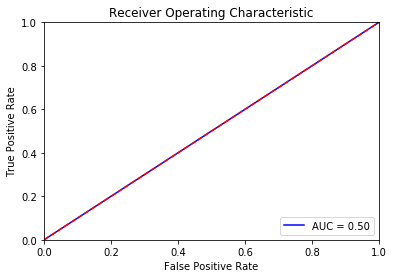

ROC_AUC Score : 0.5


In [164]:
## SVM 3 --> SVM classification with sigmoid kernel 

model_svm3 = svm.SVC(kernel='sigmoid', C=1, gamma=1)

## creating objects for Cross-validation
X = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
Y = ['Loan_Status']
cross_validation(model_svm3, df,X, Y)

## model fitting
model_svm3.fit(X_train, Y_train)
model_svm3.score(X_train, Y_train)

#Predict Output
predictions= model_svm3.predict(X_test)

#Print accuracy
accuracy = metrics.accuracy_score(Y_test,predictions)
print ("Model Accuracy : %s" % "{0:.3%}".format(accuracy))


## ROC Error metrics:

fpr, tpr, threshold = metrics.roc_curve(Y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("ROC_AUC Score : " + str(roc_auc) )


In [ ]:
## Although, SVM with sigmoid kernel reduced accuracy and cross-validation score considerably, the error metric of 
## ROC_AUC Score is 0.5 which denotes that it is a balanced dataset. 

Cross-Validation Score : 69.058%
Model Train Accuracy : 100.000%
Model Test Accuracy : 64.228%


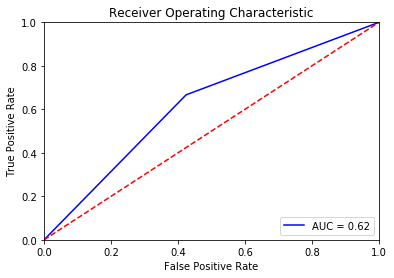

ROC_AUC Score : 0.6212121212121211


In [174]:
## 2nd Algorithm --> DT1
## Create Decision Treee with 'Gini' metric without pruning  

## Impurity measure are quite consistent with each other... Indeed, the strategy used to prune the tree 
## has a greater impact on the final tree than the choice of impurity measure.
## We choose Gini index as it focuses more on correct Classification than exploration (Entropy) 
## Also, Gini index provides better performance

model_dt1 = DecisionTreeClassifier(criterion='gini')
## creating objects for Cross-validation
X = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
Y = ['Loan_Status']
cross_validation(model_dt1, df,X, Y)



## model fitting
model_dt1.fit(X_train, Y_train)
model_dt1.score(X_train, Y_train)


#Predict Output
predictions= model_dt1.predict(X_test)

#Print train accuracy
train_accuracy = model_dt1.score(X_train,Y_train)
print ("Model Train Accuracy : %s" % "{0:.3%}".format(train_accuracy))

#Print test accuracy
test_accuracy = metrics.accuracy_score(Y_test,predictions)
print ("Model Test Accuracy : %s" % "{0:.3%}".format(test_accuracy))


## ROC Error metrics:

fpr, tpr, threshold = metrics.roc_curve(Y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("ROC_AUC Score : " + str(roc_auc) )

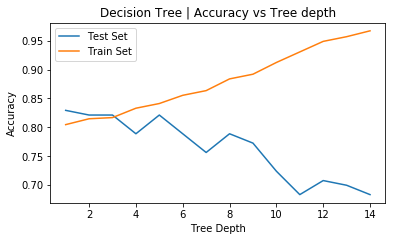

In [177]:

accuracy_test=[None]*15
accuracy_train=[None]*15
count=0
for max_depth in range(1,15):
    Decision_tree= DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    Decision_tree.fit(X_train, Y_train)
    accuracy_train[count]=Decision_tree.score(X_train, Y_train)
    accuracy_test[count]=Decision_tree.score(X_test, Y_test)
    count+=1

ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax1.plot(range(1,16),accuracy_test)
ax1.plot(range(1,16),accuracy_train)


plt.title("Decision Tree | Accuracy vs Tree depth")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")

plt.legend(['Test Set','Train Set'])


In [ ]:
The accuraccy of the train dataset increases as the tree depth increases and eventually the it reaches to 1, which 
results to the overfitting of the model. 

The accuracy of the test dataset increases as the depth increases but after certain depth is starts to decreases, 
which is expected. From the graph of accuracy as the function of tree depth, it as clear that for this dataset 
the optimum tree depth is 7. 

Cross-Validation Score : 77.361%
Model Train Accuracy : 86.354%
Model Test Accuracy : 75.610%


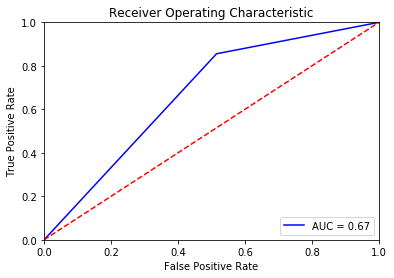

ROC_AUC Score : 0.6702020202020202


In [178]:
## 2nd Algorithm --> DT2 (with depth = 7)
## Create Decision Treee with 'Gini' metric with pruning for better performance


model_dt2 = DecisionTreeClassifier(criterion='gini',random_state=0, max_depth=7)
## creating objects for Cross-validation
X = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
Y = ['Loan_Status']
cross_validation(model_dt2, df,X, Y)



## model fitting
model_dt2.fit(X_train, Y_train)
model_dt2.score(X_train, Y_train)


#Predict Output
predictions= model_dt2.predict(X_test)

#Print train accuracy
train_accuracy = model_dt2.score(X_train,Y_train)
print ("Model Train Accuracy : %s" % "{0:.3%}".format(train_accuracy))

#Print test accuracy
test_accuracy = metrics.accuracy_score(Y_test,predictions)
print ("Model Test Accuracy : %s" % "{0:.3%}".format(test_accuracy))


## ROC Error metrics:

fpr, tpr, threshold = metrics.roc_curve(Y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("ROC_AUC Score : " + str(roc_auc) )




In [179]:
## As we see the Test Accuracy of the model i.e. performance increased after pruning

Cross-Validation Score : 69.544%
Model Train Accuracy : 100.000%
Model Test Accuracy : 66.667%


C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

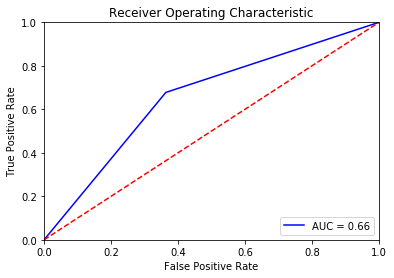

ROC_AUC Score : 0.6570707070707071


In [184]:
## 3rd Algorithm --> Boosting Ensemble methods with Decision tree without boosting

Decision_tree= DecisionTreeClassifier( criterion='gini')
model_boost = AdaBoostClassifier(base_estimator=Decision_tree)
## creating objects for Cross-validation
X = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
Y = ['Loan_Status']
cross_validation(model_boost, df,X, Y)



## model fitting
model_boost.fit(X_train, Y_train)
model_boost.score(X_train, Y_train)


#Predict Output
predictions= model_boost.predict(X_test)

#Print train accuracy
train_accuracy = model_boost.score(X_train,Y_train)
print ("Model Train Accuracy : %s" % "{0:.3%}".format(train_accuracy))

#Print test accuracy
test_accuracy = metrics.accuracy_score(Y_test,predictions)
print ("Model Test Accuracy : %s" % "{0:.3%}".format(test_accuracy))


## ROC_AUC Error metrics:

fpr, tpr, threshold = metrics.roc_curve(Y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("ROC_AUC Score : " + str(roc_auc) )

C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

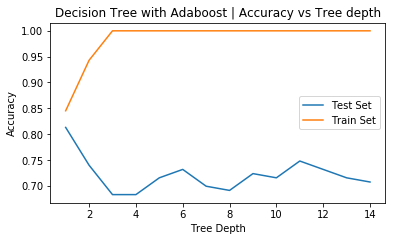

In [186]:
accuracy_test=[None]*15
accuracy_train=[None]*15
count=0
for max_depth in range(1,15):
    Decision_tree= DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    Adaboost_Classifier = AdaBoostClassifier(base_estimator=Decision_tree)
    Adaboost_Classifier.fit(X_train, Y_train)
    accuracy_train[count]=Adaboost_Classifier.score(X_train, Y_train)
    accuracy_test[count]=Adaboost_Classifier.score(X_test, Y_test)
    count+=1
    

ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax1.plot(range(1,16),accuracy_test)
ax1.plot(range(1,16),accuracy_train)


plt.title("Decision Tree with Adaboost | Accuracy vs Tree depth")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")

plt.legend(['Test Set','Train Set'])

C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\VisualBI\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Cross-Validation Score : 74.926%
Model Train Accuracy : 100.000%
Model Test Accuracy : 72.358%


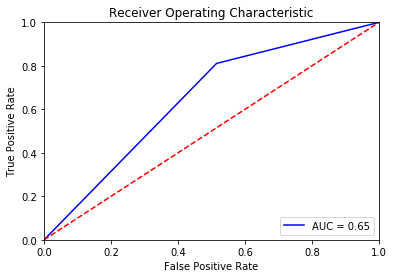

ROC_AUC Score : 0.647979797979798


In [187]:
## 3rd Algorithm --> Boosting Ensemble methods with Decision tree with pruning

Decision_tree= DecisionTreeClassifier( criterion='gini', max_depth=6)
model_boost2 = AdaBoostClassifier(base_estimator=Decision_tree)
## creating objects for Cross-validation
X = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
Y = ['Loan_Status']
cross_validation(model_boost2, df,X, Y)



## model fitting
model_boost2.fit(X_train, Y_train)
model_boost2.score(X_train, Y_train)


#Predict Output
predictions= model_boost2.predict(X_test)

#Print train accuracy
train_accuracy = model_boost2.score(X_train,Y_train)
print ("Model Train Accuracy : %s" % "{0:.3%}".format(train_accuracy))

#Print test accuracy
test_accuracy = metrics.accuracy_score(Y_test,predictions)
print ("Model Test Accuracy : %s" % "{0:.3%}".format(test_accuracy))


## ROC_AUC Error metrics:

fpr, tpr, threshold = metrics.roc_curve(Y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("ROC_AUC Score : " + str(roc_auc) )

In [ ]:
## As expected the Test_Accuracy of the model inreases to 72.35% improving the performance due to pruning